1. https://data.caltech.edu/records/20098
2. https://www.kaggle.com/code/anuragmishra2311/birds-classification-using-resnet-101/notebook
3. https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [1]:
import os
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications import ResNet101V2, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
train_directory='../../../../../DataSets/IMG-100/train'
val_directory='../../../../../DataSets/IMG-100/valid'
test_directory='../../../../../DataSets/IMG-100/test'

In [3]:
train_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
train_generator=train_datagen.flow_from_directory(train_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=16)

val_generator=val_datagen.flow_from_directory(val_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=16)
                                                 
                                                 
test_gemerator=test_datagen.flow_from_directory(test_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=16)

Found 822 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [5]:
train_generator.class_indices;

## ResNet - 101

In [6]:
convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

In [7]:
model = Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(225, activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              205522944 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [8]:
opt=tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer=opt)
history = model.fit(train_generator, validation_data=val_generator,
                      epochs=6)


c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/6
52/52 [==============================] - 213s 4s/step - loss: 1.8128 - accuracy: 0.7214 - val_loss: 0.0965 - val_accuracy: 1.0000
Epoch 2/6
52/52 [==============================] - 204s 4s/step - loss: 0.1639 - accuracy: 0.9805 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 3/6
52/52 [==============================] - 207s 4s/step - loss: 0.0501 - accuracy: 0.9964 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 4/6
52/52 [==============================] - 207s 4s/step - loss: 0.0212 - accuracy: 0.9964 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/6
52/52 [==============================] - 205s 4s/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/6
52/52 [==============================] - 205s 4s/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 6.3783e-04 - val_accuracy: 1.0000


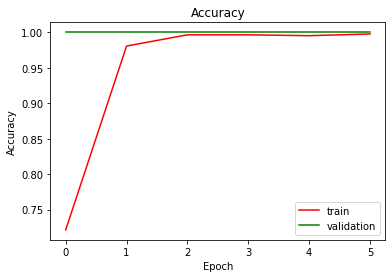

In [10]:
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='lower right')

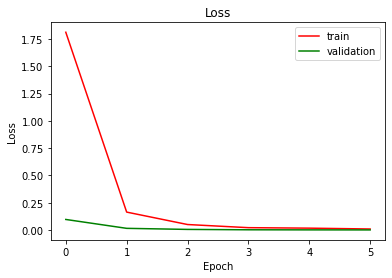

In [11]:
plt.plot(history.history['loss'],c='red')
plt.plot(history.history['val_loss'],c='green')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')

In [12]:
model.evaluate(test_gemerator)


2/2 [==============================] - 5s 2s/step - loss: 0.0218 - accuracy: 1.0000


[0.0217983927577734, 1.0]

In [13]:
def predict_prob(number):
  return [number[0],1-number[0]]


In [14]:
dic=train_generator.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    # answer=model.predict_classes(img)
    predict_x=model.predict(img) 
    classes_x=np.argmax(predict_x,axis=1)
    answer = icd[classes_x[0]]
    
    prob = np.array(list(map(predict_prob, model.predict(img))))
    prob = prob[0].flatten()
    prob = prob[0] * 100
    print (prob, ' % chances are there that the Bird Is',answer)

99.9996542930603  % chances are there that the Bird Is ANNAS HUMMINGBIRD


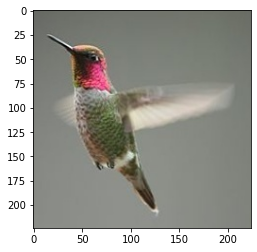

In [15]:
img='../../../../../DataSets/IMG-100/images to test/1.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/1.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

0.0004188654202152975  % chances are there that the Bird Is ANTBIRD


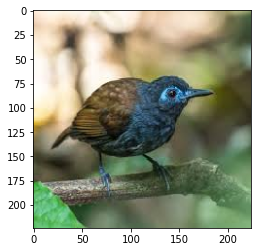

In [16]:
img='../../../../../DataSets/IMG-100/images to test/2.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/2.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

0.04291907825972885  % chances are there that the Bird Is BARN SWALLOW


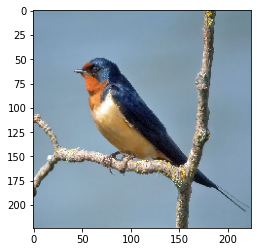

In [17]:
img='../../../../../DataSets/IMG-100/images to test/3.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/3.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [18]:
category_count = len(np.unique(test_gemerator.classes))
train_groups = test_gemerator.samples
valid_groups = val_generator.samples

## AlexNet 2012 - Self Created Not Avaialbe in Keras

In [35]:
backend.clear_session()
model_alexnet = Sequential()

# Layer 1
model_alexnet.add(Conv2D(64, (3, 3), padding='same', input_shape=(224,224,3)))  # 224X224
model_alexnet.add(Activation('relu'))
model_alexnet.add(BatchNormalization())

# Layer 2
model_alexnet.add(Conv2D(64, (3, 3)))  # 222x222
model_alexnet.add(Activation('relu'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2)))  # 111x111
model_alexnet.add(BatchNormalization())

# Layer 3
model_alexnet.add(Conv2D(64, (3, 3), padding='same'))
model_alexnet.add(Activation('relu'))
model_alexnet.add(BatchNormalization())


# Layer 4
model_alexnet.add(Conv2D(64, (3, 3)))  # 109x109
model_alexnet.add(Activation('relu'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2)))  # 54x54
model_alexnet.add(BatchNormalization())
model_alexnet.add(Dropout(0.35))  # 64 --> 42

# Layer 5
model_alexnet.add(Conv2D(64, (3, 3), padding='same'))  # 54x54
model_alexnet.add(Activation('relu'))
model_alexnet.add(BatchNormalization())

# Layer 6
model_alexnet.add(Conv2D(64, (3, 3), padding='same'))  # 54x54
model_alexnet.add(Activation('relu'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2)))  # 27x27
model_alexnet.add(BatchNormalization())

# Layer 7
model_alexnet.add(Flatten())
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(225))
model_alexnet.add(Activation('relu'))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Dense(1))  # Updated for number of classes
model_alexnet.add(Activation('softmax'))

model_alexnet.summary()

#Compile
model_alexnet.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                      

c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [36]:
#fit model
history_alexnet = model_alexnet.fit_generator(
    train_generator,
    steps_per_epoch=train_groups,
    epochs=15,
    validation_data=val_generator,
    validation_steps=valid_groups,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=2, verbose=1)])


Epoch 1/15


C:\Users\sunil\AppData\Local\Temp\ipykernel_3092\1151162246.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_alexnet = model_alexnet.fit_generator(


30/30 [==============================] - 126s 4s/step - loss: 0.0000e+00 - accuracy: 0.1875 - val_loss: 0.0000e+00 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/15
30/30 [==============================] - 115s 4s/step - loss: 0.0000e+00 - accuracy: 0.1851 - lr: 0.0010
Epoch 3/15
30/30 [==============================] - 113s 4s/step - loss: 0.0000e+00 - accuracy: 0.1896 - lr: 0.0010
Epoch 4/15
30/30 [==============================] - 112s 4s/step - loss: 0.0000e+00 - accuracy: 0.1745 - lr: 0.0010
Epoch 5/15
30/30 [==============================] - 112s 4s/step - loss: 0.0000e+00 - accuracy: 0.1851 - lr: 0.0010
Epoch 6/15
30/30 [==============================] - 111s 4s/step - loss: 0.0000e+00 - accuracy: 0.2000 - lr: 0.0010
Epoch 7/15
30/30 [==============================] - 114s 4s/step - loss: 0.0000e+00 - accuracy: 0.1896 - lr: 0.0010
Epoch 8/15
30/30 [==============================] - 113s 4s/step - loss: 0.0000e+00 - accuracy: 0.2021 - lr: 0.0010
Epoch 9/15
30/30 [===================

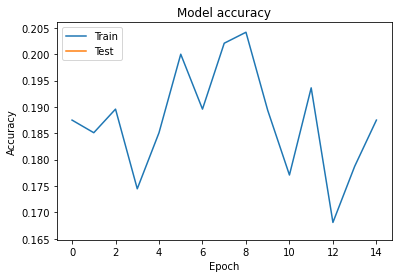

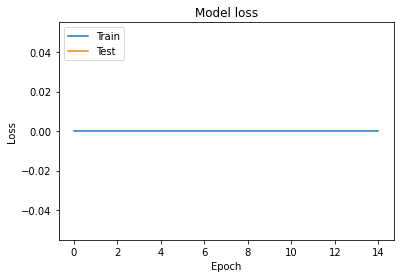

2/2 [==============================] - 2s 889ms/step - loss: 0.0000e+00 - accuracy: 0.1667
Test loss: 0.0
Test accuracy: 0.1666666716337204


In [37]:
plt.plot(history_alexnet.history['accuracy'])
plt.plot(history_alexnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history_alexnet.history['loss'])
plt.plot(history_alexnet.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores_alexnet = model_alexnet.evaluate(test_gemerator, verbose=1)
print('Test loss:', scores_alexnet[0])
print('Test accuracy:', scores_alexnet[1])


In [38]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    # answer=model.predict_classes(img)
    predict_x = model_alexnet.predict(img)
    classes_x=np.argmax(predict_x,axis=1)
    answer = icd[classes_x[0]]
    
    prob = np.array(list(map(predict_prob, model_alexnet.predict(img))))
    prob = prob[0].flatten()
    prob = prob[0] * 100
    print (prob, ' % chances are there that the Bird Is',answer)

100.0  % chances are there that the Bird Is ANNAS HUMMINGBIRD


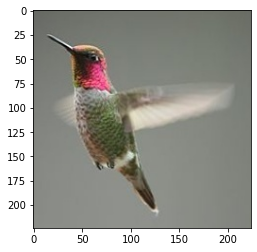

In [39]:
img = '../../../../../DataSets/IMG-100/images to test/1.jpg'
pic = load_img('../../../../../DataSets/IMG-100/images to test/1.jpg',
               target_size=(224, 224, 3))
plt.imshow(pic)
output(img)


## VGG16 - 2014

In [29]:
backend.clear_session()

base_vgg16 = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))
base_vgg16.trainable = False  # Freeze the VGG16 weights.

model_vgg16 = Sequential()
model_vgg16.add(base_vgg16)

model_vgg16.add(Flatten())  # 1024#model_vgg16.add(Dense(256))
model_vgg16.add(Activation('relu'))
model_vgg16.add(Dense(1))
model_vgg16.add(Activation('softmax'))

model_vgg16.summary()

#Compile
model_vgg16.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 activation (Activation)     (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
history_vgg16 = model_vgg16.fit_generator(
    train_generator,
    steps_per_epoch=train_groups,
    epochs=5,
    validation_data=val_generator,
    validation_steps=valid_groups,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.7,  # 0.2 to 0.5 dropped to fast 0.7
                                                                                                               patience=2, verbose=1)])


Epoch 1/5


C:\Users\sunil\AppData\Local\Temp\ipykernel_3092\2346692469.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16 = model_vgg16.fit_generator(


30/30 [==============================] - 105s 3s/step - loss: 0.0000e+00 - accuracy: 0.1745 - val_loss: 0.0000e+00 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/5
30/30 [==============================] - 99s 3s/step - loss: 0.0000e+00 - accuracy: 0.1792 - lr: 0.0010
Epoch 3/5
30/30 [==============================] - 107s 4s/step - loss: 0.0000e+00 - accuracy: 0.1750 - lr: 0.0010
Epoch 4/5
30/30 [==============================] - 98s 3s/step - loss: 0.0000e+00 - accuracy: 0.1809 - lr: 0.0010
Epoch 5/5
30/30 [==============================] - 101s 3s/step - loss: 0.0000e+00 - accuracy: 0.1708 - lr: 0.0010


tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr

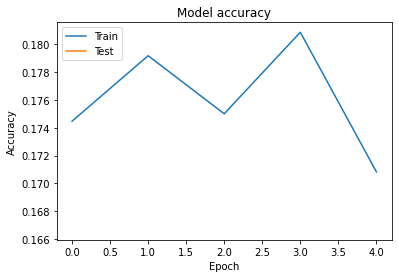

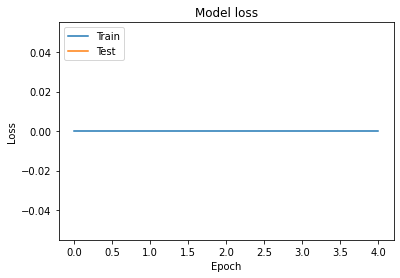

2/2 [==============================] - 6s 3s/step - loss: 0.0000e+00 - accuracy: 0.1667
Test loss: 0.0
Test accuracy: 0.1666666716337204


In [31]:
#plot accuracy vs epoch
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores_vgg16 = model_vgg16.evaluate(test_gemerator, verbose=1)
print('Test loss:', scores_vgg16[0])
print('Test accuracy:', scores_vgg16[1])


In [40]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    # answer=model.predict_classes(img)
    predict_x = model_vgg16.predict(img)
    classes_x=np.argmax(predict_x,axis=1)
    answer = icd[classes_x[0]]
    
    prob = np.array(list(map(predict_prob, model_vgg16.predict(img))))
    prob = prob[0].flatten()
    prob = prob[0] * 100
    print (prob, ' % chances are there that the Bird Is',answer)

100.0  % chances are there that the Bird Is ANNAS HUMMINGBIRD


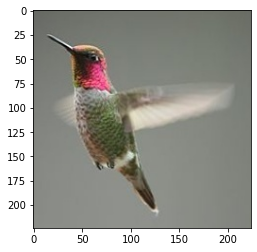

In [41]:
img = '../../../../../DataSets/IMG-100/images to test/1.jpg'
pic = load_img('../../../../../DataSets/IMG-100/images to test/1.jpg',
               target_size=(224, 224, 3))
plt.imshow(pic)
output(img)
